In [1]:
import statistics
import math

def calculate_flexibility(machines_for_all_operations, n_machines): 
    counts = []

    for m in machines_for_all_operations:
        counts.append(len(m))
    
    return statistics.mean(counts) / n_machines

def calculate_duration_variety(durations):
    counts = []

    for d in durations:
        counts.append(len(d))

    return len(set(counts)) / len(counts)

def calculate_average_operations(job_sequence):
    n_jobs = 1
    counts = [1]
    for i in range(1, len(job_sequence)):
        if job_sequence[i] != job_sequence[i-1]:
            n_jobs+=1
            counts.append(0)
        counts[-1] += 1
    return (sum(counts))/n_jobs


In [2]:
def calculate_duration_features_workers(durations):
    all_durations = []
    for duration in durations:
        for d in duration:
            all_durations.extend(d)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    stdev = statistics.stdev(all_durations)
    return min_duration, max_duration, span, stdev

def calculate_duration_features(durations):
    all_durations = []
    for duration in durations:
        all_durations.extend(duration)
    all_durations = [d for d in all_durations if d != 0]
    min_duration = min(all_durations)
    max_duration = max(all_durations)
    span = max_duration - min_duration
    #stdev = statistics.stdev(all_durations)
    mean = sum(all_durations)/len(all_durations)
    var = sum(pow(x-mean, 2) for x in all_durations) / len(all_durations)
    stdev = math.sqrt(var)
    return min_duration, max_duration, span, stdev


In [3]:
from benchmarkrewriter.benchmark_parser import WorkerBenchmarkParser, BenchmarkParser
import os
includeWorkers = False
if includeWorkers:
    path = r'C:\Users\huda\Downloads\benchmarks_with_workers\benchmarks_with_workers'
    parser = WorkerBenchmarkParser()
else:
    path = r'C:\Users\huda\Documents\GitHub\scheduling_model_jrc\code\upgrades\benchmarks\all'
    parser = BenchmarkParser()
instances = os.listdir(path)
instance_data = []
feature_vectors = []
consider_duration_features = True
for instance in instances:
    encoding = parser.parse_benchmark(path + "\\" + instance)
    feature_vector = []
    min_d, max_d, d_span, d_stdev = calculate_duration_features(encoding.durations())
    #TODO: worker data, or just do it with base FJSSP since all benchmarks are transformed in the same way
    extracted_data = {
        "name": instance,
        "n_jobs": encoding.n_jobs(), 
        "n_machines": encoding.n_machines(),
        "n_operations": encoding.n_operations(),
        "durations": encoding.durations(),
        "job_sequence": encoding.job_sequence(),
        "machines_for_all_operations": encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(),
        "flexibility": calculate_flexibility(encoding.get_all_machines_for_all_operations() if includeWorkers else encoding.get_machines_for_all_operations(), encoding.n_machines()),
        "duration_variety": calculate_duration_variety(encoding.durations()),
        "average_operations": calculate_average_operations(encoding.job_sequence()),
        "min_duration": min_d,
        "max_duration": max_d,
        "duration_span": d_span,
        "duration_std": d_stdev
    }
    feature_vector = [encoding.n_jobs(), encoding.n_machines(), encoding.n_operations(), extracted_data["flexibility"], extracted_data["duration_variety"], extracted_data["average_operations"]]
    if consider_duration_features:
        feature_vector.extend([min_d, max_d, d_span, d_stdev])
    feature_vectors.append(feature_vector)
    instance_data.append(extracted_data)


AttributeError: 'Encoding' object has no attribute 'get_all_machines_for_all_operations'

In [51]:
from sklearn.cluster import KMeans
inertias = []
n_clusters = 20
centers = []
results = []
for i in range(1, n_clusters+1):
    kmeans = KMeans(n_clusters=i)
    results.append(kmeans.fit_predict(feature_vectors))
    centers.append(kmeans.cluster_centers_)
    
    inertias.append(kmeans.inertia_)


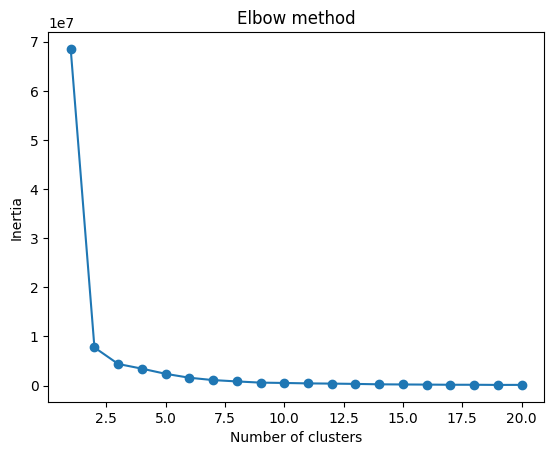

In [52]:
import matplotlib.pyplot as plt
plt.plot(range(1,n_clusters+1), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [53]:
results[n_clusters-1]

array([ 7,  8,  8,  8,  8,  8,  5,  5,  5,  5, 13,  5, 13, 13, 13, 13, 13,
        7,  7,  7,  7, 13,  7,  8,  8,  8,  8,  8,  5,  5,  5,  5, 13,  5,
       13, 13, 13, 13, 13,  7,  7,  7,  7, 13,  7,  8,  8,  8,  8,  8,  5,
        5,  5,  5, 13,  5,  7,  7,  7,  7,  4,  8,  8,  8, 11, 11, 13, 13,
        7,  7,  7,  7,  7,  8,  6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       13, 10, 10, 10, 10, 14, 14, 14, 14, 14,  4, 10,  4,  4,  4,  4, 17,
       17, 17, 17, 17,  4, 10,  4,  4,  4,  4, 10, 10, 11, 11, 11,  1,  0,
       15, 12,  1,  1,  1, 15, 15, 10, 10, 10,  0, 10, 10, 10,  7, 10, 10,
       10,  0,  0,  0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10,
       10, 10, 10, 14, 14, 14, 14, 14,  4, 10,  4,  4,  4,  4, 17, 17, 17,
       17, 17,  4, 10,  4,  4,  4,  4, 10, 10, 11, 11, 11,  1,  0,  1, 12,
       15,  1,  1, 15, 15, 10, 10, 10,  0, 10, 10, 10,  7, 10, 10, 10,  0,
        0,  0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10,
       10, 14, 14, 14, 14

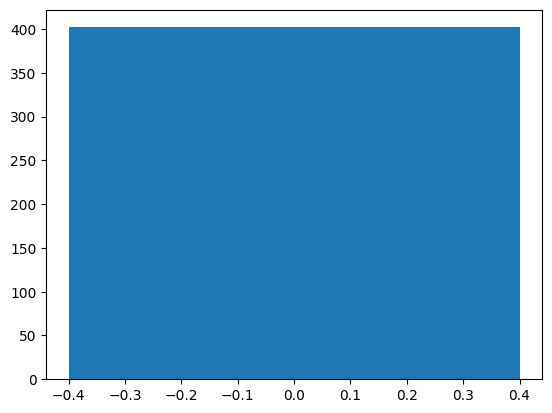

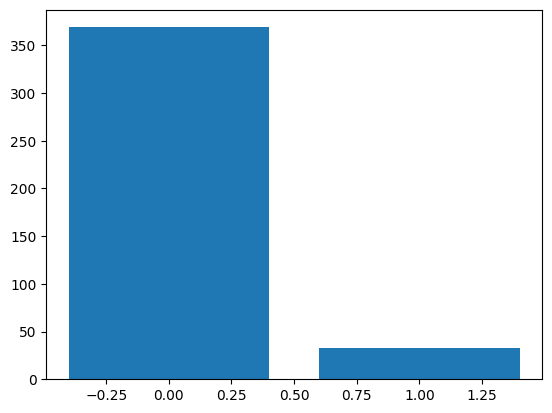

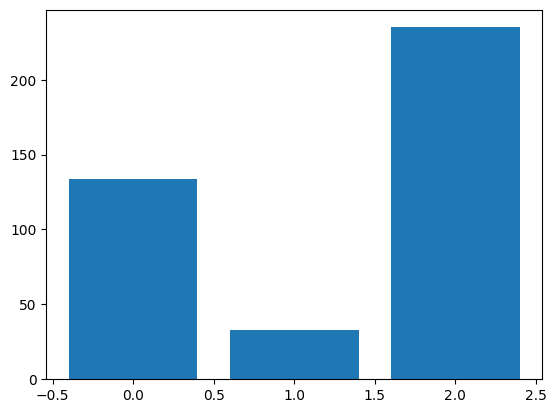

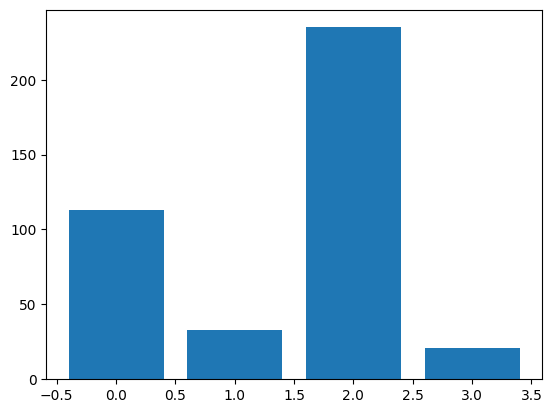

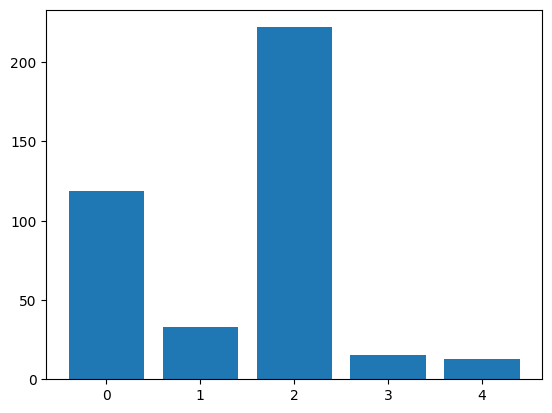

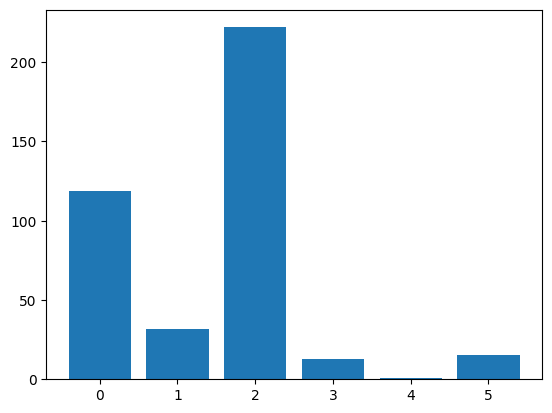

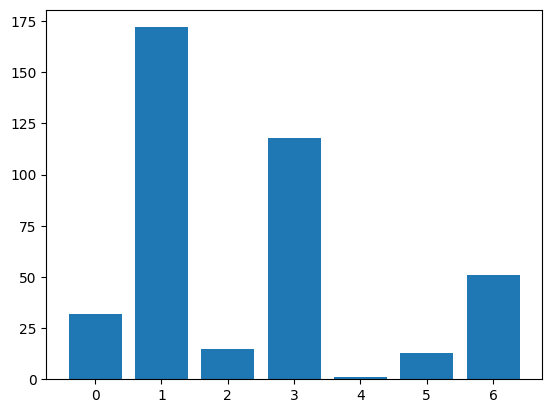

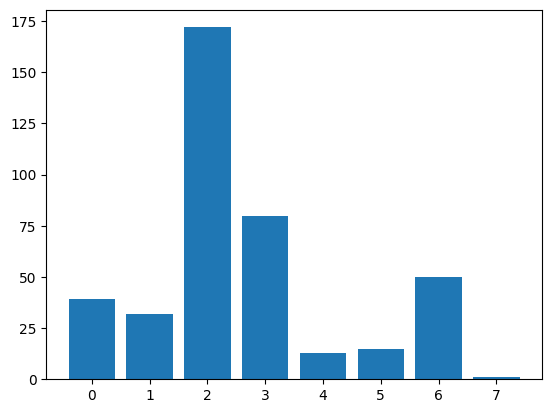

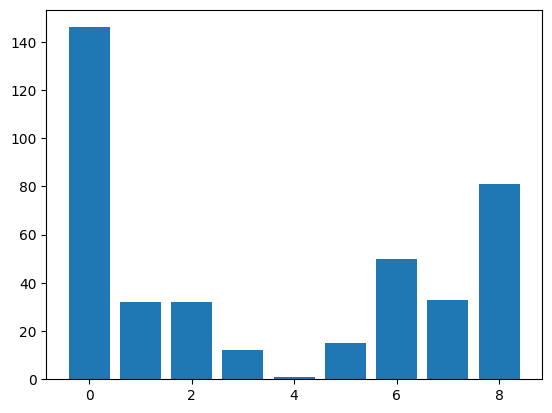

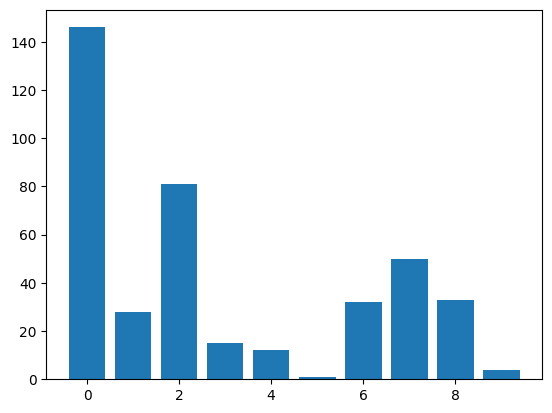

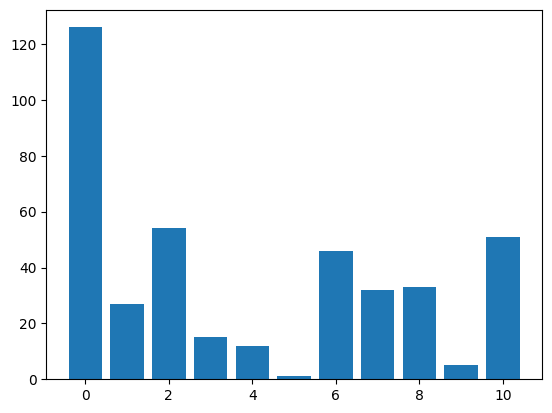

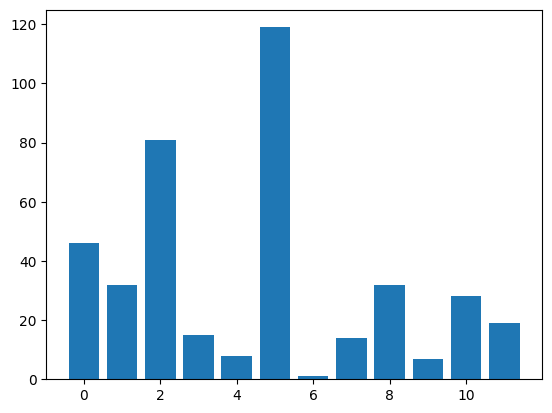

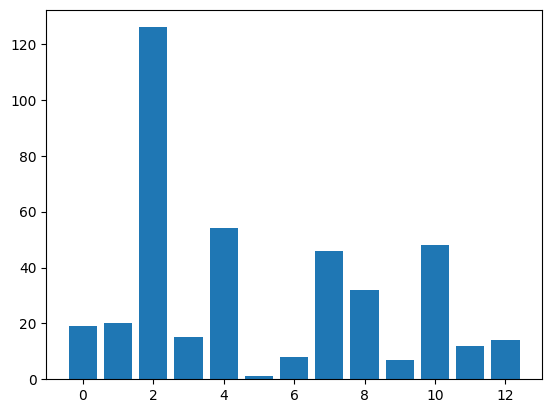

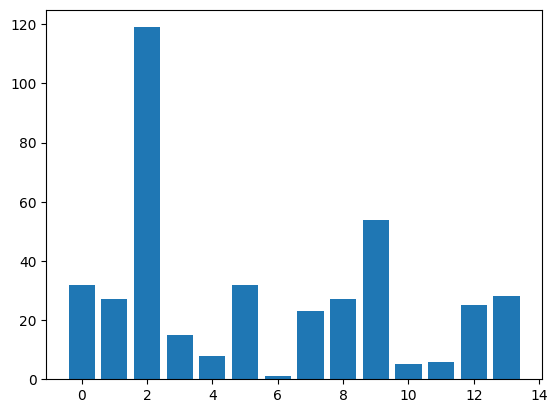

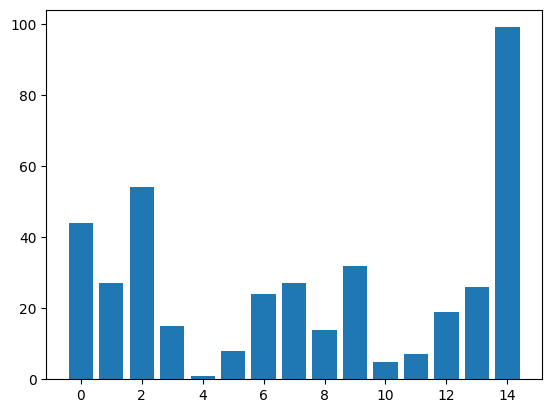

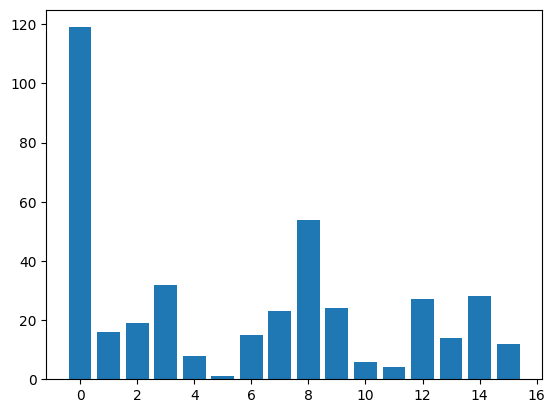

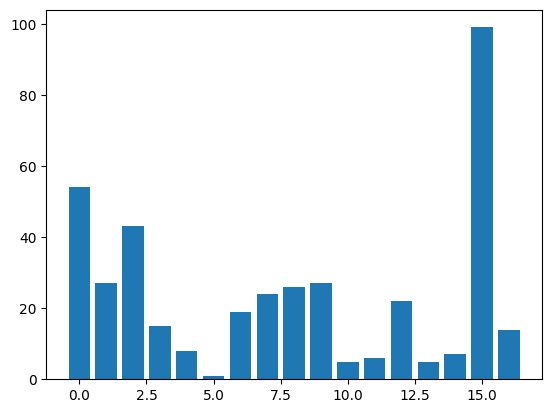

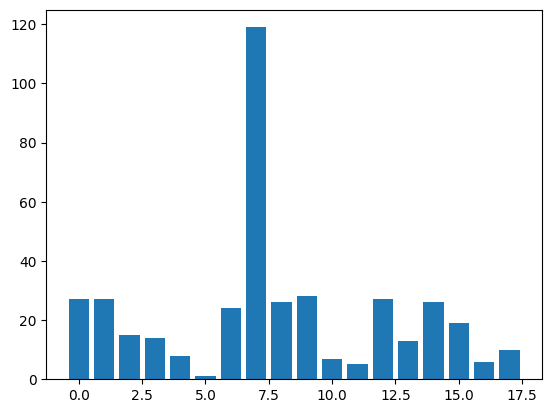

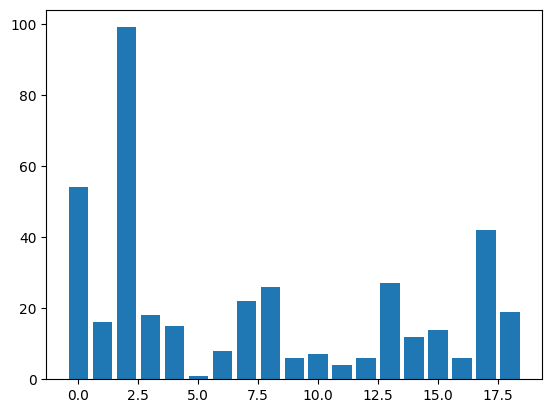

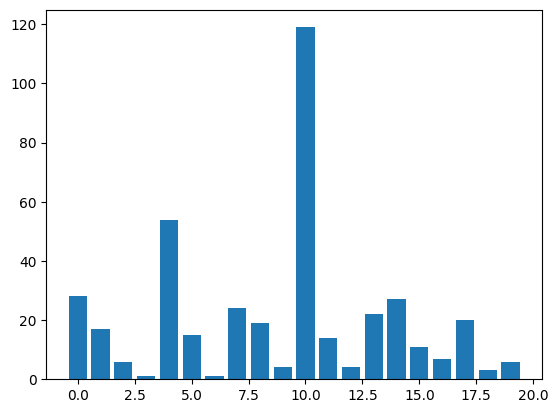

In [54]:
def counts(result):
    bars = [0] * (max(result)+1)
    for value in result:
        bars[value] += 1
    return bars

for i in range(len(results)):
    result = results[i]
    plt.bar(range(0,max(result)+1), counts(result))
    plt.show()
